Challenge_1: Aerial Cactus-AML

In [1]:
# Imports
%reset -f
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import wandb
from datasets.CactusDataset import CactusDataset
from models.CactusResNet50 import CactusModel
from torch.utils.data import ConcatDataset

In [2]:
log = True
# free gpu
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Phase 1: Loading the data, analyzing it, doing feature engineering and creating the Loader

In [3]:
# load data for displaying
dataset=CactusDataset()
# take the first sample from train_dataloader
train_features, train_labels = dataset[0]
image_np = np.array(train_features)
print("Image shape: "+str(image_np.shape))
print("Image python class"+str(type(train_features)))
print("Label: "+str(train_labels))

Image shape: (32, 32, 3)
Image python class<class 'PIL.Image.Image'>
Label: 1


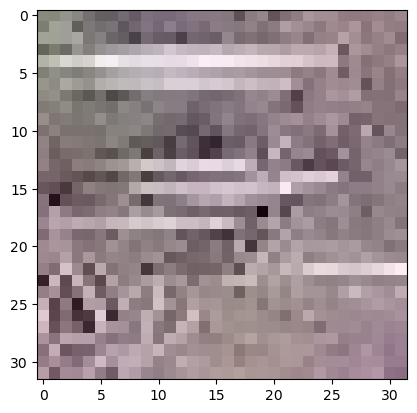

In [4]:
# show the image
plt.imshow(image_np)

has_cactus
0     4364
1    13136
Name: count, dtype: int64


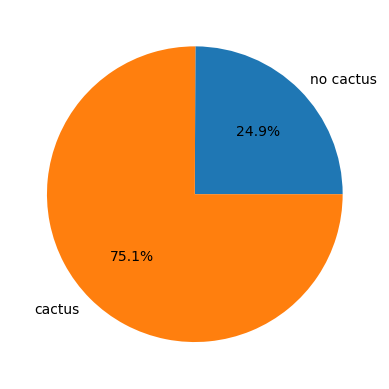

In [5]:
label_distribution = dataset.label_distribution() # they are sorted in ascending order
print(label_distribution)
fig, ax = plt.subplots()
ax.pie(label_distribution, labels=['no cactus','cactus'], autopct='%1.1f%%')
plt.show()

In [6]:
print("Number of train values: "+str(dataset.__len__()))

Number of train values: 17500


Image python class<class 'torch.Tensor'>
Image shape: torch.Size([3, 224, 224])
Label shape: 1


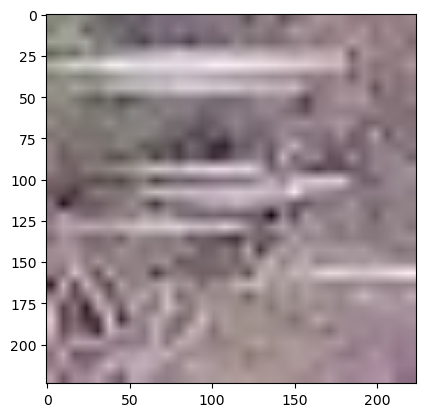

In [7]:
transform_dataset = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = CactusDataset(transform=transform_dataset)
image, label = dataset[0]
print("Image python class"+str(type(image)))
print("Image shape: "+str(image.shape))
print("Label shape: "+str(label))
# show the image
plt.imshow(image.permute(1,2,0))

In [8]:
dataloader=DataLoader(dataset,batch_size=32,shuffle=True)

In [9]:
for i, (images, labels) in enumerate(dataloader):
    print("Batch number: "+str(i))
    print("Batch images shape: "+str(images.shape))
    print("Batch labels shape: "+str(labels.shape))
    break

Batch number: 0
Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


In [10]:
# --------- DATA AUGMENTATION ---------
# filter the dataset to only have no cactus images
dataset = CactusDataset(transform=transform_dataset)
no_cactus_dataset = dataset.filter(0)
# create a concatenated dataset with an equal number of cactus and no cactus images
print("Number of no cactus images: "+str(no_cactus_dataset.__len__()))
print("Number of cactus images: "+str(dataset.__len__()-no_cactus_dataset.__len__()))
def compute_mean_std(dataset):
    mean = 0.
    std = 0.
    for images, _ in dataset:
        mean += images.mean()
        std += images.std()
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std
mean, std = compute_mean_std(ConcatDataset([dataset, no_cactus_dataset, no_cactus_dataset]))
print("Mean: "+str(mean))
print("Std: "+str(std))

Number of no cactus images: 4364
Number of cactus images: 13136
Mean: tensor(0.4809)
Std: tensor(0.0906)


In [11]:
merged_dataset_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

dataset=CactusDataset(transform=merged_dataset_transforms)
no_cactus_dataset=dataset.filter(0)
dataset_merged=ConcatDataset([dataset,no_cactus_dataset,no_cactus_dataset])

In [12]:
# --------- CREATING THE DATA LOADER AND TRAIN/VAL SPLIT ---------
dataset_used=dataset_merged
train_size = int(0.8 * len(dataset_used))
print("Train size: " + str(train_size))
test_size = len(dataset_used) - train_size
print("Test size: " + str(test_size))
train_dataset, val_dataset = torch.utils.data.random_split(dataset_used, [train_size, test_size])

# Retrieve the lengths of the datasets
print("dataset length: " + str(len(dataset_used)))


# Create DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,pin_memory=True)
#print a sample
image,label=dataset_used.__getitem__(0)
print("Image shape: "+str(image.shape))
print("Label shape: "+str(label))

Train size: 20982
Test size: 5246
dataset length: 26228
Image shape: torch.Size([3, 224, 224])
Label shape: 1



 # Phase 2: defining the model

In [13]:
if log:
    # setting wandb
    wandb.login()

wandb: Currently logged in as: micheleferrero9 (ai-ml-monitor). Use `wandb login --relogin` to force relogin


In [14]:
if log:
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="Challenge_1",
    
        # track hyperparameters and run metadata
        config={
        "architecture": "ResNet50_FineTuned",
        "dataset": "Cactus",
        "freeze_epochs": 1,
        "freeze_learning_rate": 0.1,
        "epochs": 4,
        "learning_rate": 0.01,
        "batch_size": 32,
        }
    )

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CactusModel()
model.to(device)
print(model)

CactusModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [16]:
def get_label_distribution(dataset):
    label_counts = {}
    for _, label in dataset:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1
    sorted_distribution = sorted(label_counts.items(), key=lambda x: x[0], reverse=True)
    return sorted_distribution
# train the model
if log==True:
    # Create DataLoader for training and validation
    train_dataloader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    model.train_model(train_dataloader, val_dataloader, epochs=wandb.config.freeze_epochs, lr=wandb.config.freeze_learning_rate, device=device, wandb=wandb, freeze=True)
    model.train_model(train_dataloader, val_dataloader, epochs=wandb.config.epochs, lr=wandb.config.learning_rate, device=device, wandb=wandb)

Training on: cuda
Epoch: 0 Batch: 0 Loss train: 0.7731078863143921
Epoch: 0 Batch: 1 Loss train: 238.68234252929688
Epoch: 0 Batch: 2 Loss train: 277.90435791015625
Epoch: 0 Batch: 3 Loss train: 187.1362762451172
Epoch: 0 Batch: 4 Loss train: 69.21246337890625
Epoch: 0 Batch: 5 Loss train: 79.37307739257812
Epoch: 0 Batch: 6 Loss train: 71.15056610107422
Epoch: 0 Batch: 7 Loss train: 50.40005111694336
Epoch: 0 Batch: 8 Loss train: 44.06360626220703
Epoch: 0 Batch: 9 Loss train: 25.342819213867188
Epoch: 0 Batch: 10 Loss train: 11.275557518005371
Epoch: 0 Batch: 11 Loss train: 17.668169021606445
Epoch: 0 Batch: 12 Loss train: 2.4539310932159424
Epoch: 0 Batch: 13 Loss train: 3.0136120319366455
Epoch: 0 Batch: 14 Loss train: 1.8559961318969727
Epoch: 0 Batch: 15 Loss train: 1.9496653079986572
Epoch: 0 Batch: 16 Loss train: 4.2004241943359375
Epoch: 0 Batch: 17 Loss train: 0.5784154534339905
Epoch: 0 Batch: 18 Loss train: 0.47095581889152527
Epoch: 0 Batch: 19 Loss train: 0.70463341474533

KeyboardInterrupt: 

In [ ]:
if log:
    from sklearn.metrics import confusion_matrix
    # use it to classify training and validation
    train_transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
    
    # load the train dataset without transforms
    train_dataset = CactusDataset(train='./data/train/train', labels='./data/train.csv', transform=train_transform)
    # create the data loader
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    out=model.predict_model(train_dataloader, device)
    #if the first value is higher than 50% take 0 otherwise 1
    out = [0 if x[0]>0.5 else 1 for x in out]
    # generate the confusion matrix
    cm = confusion_matrix(train_dataset.df.get('has_cactus'), out)
    print(cm)

In [ ]:
if log:
    # use it to classify the test
    test_transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
    
    # load the test dataset
    test_dataset = CactusDataset(train='./data/test/test', labels=None, transform=test_transform)
    # create the data loader
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    out=model.predict_model(test_dataloader, device, './data/submission.csv')
    print(out)

In [ ]:
# now using custom made resnet34
from models.CustomResNet34 import CustomResNet34
train_custom=True
model = CustomResNet34()
model.to(device)
print(model)

In [ ]:
if train_custom==False:
    wandb.login()

In [ ]:
if train_custom==True:
    wandb.init(
        project="Challenge_1",
        config={
        "architecture": "ResNet34_CustomMade",
        "dataset": "Cactus",
        "epochs": 40,
        "learning_rate": 0.1,
        "batch_size": 32,
        }
    )

In [ ]:
# train the model
if train_custom==True:
    train_dataloader = DataLoader(train_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=wandb.config.batch_size, shuffle=True,pin_memory=True)
    model.train_model(train_dataloader, val_dataloader, epochs=wandb.config.epochs, lr=wandb.config.learning_rate, device=device, wandb=wandb)